In [103]:
import numpy as np
from tqdm import tqdm
from geographiclib.geodesic import Geodesic
import torch_geometric as ptg
import torch
import warnings
import matplotlib.pyplot as plt
import argparse

import tgnn4i.constants as constants
import tgnn4i.pred_dists as pred_dists
from tgnn4i.gru_model import GRUModel
from tgnn4i.gru_node_model import GRUNodeModel
from tgnn4i.gru_graph_model import GRUGraphModel
from tgnn4i.transformer import TransformerForecaster
from tgnn4i.transformer_joint import TransformerJointForecaster
from tgnn4i.utils import parse_loss_weight
import utils
import pickle
import geopandas as gpd
import pandas as pd

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [3]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')
master_day = insar.get_master_day()
gnss = GNSS('data/selected_stations_dates.csv', master_day)

Computing zscores and removing outliers for InSAR...


100%|██████████| 218637/218637 [00:59<00:00, 3697.95it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/

In [4]:
gnss.filter_signal(insar.sampling_freq/5)
insar.filter_signal(insar.sampling_freq/5)
gnss.take_derivative()
insar.take_derivative()

Filtering InSAR signal...
Using raw dataset


100%|██████████| 218637/218637 [01:39<00:00, 2191.81it/s]


Taking derivative of InSAR signal...
Using filtered dataset


100%|██████████| 218637/218637 [00:12<00:00, 17100.49it/s]


longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122       0.0  0.008536  0.015141  0.004221   
1        6.520702  49.001022       0.0  0.017279  0.027520  0.017710   
2        6.520345  49.001186       0.0 -0.001677  0.003752  0.030320   
3        6.522241  49.000980       0.0  0.012220  0.020581  0.015715   
4        6.522860  49.000912       0.0  0.026324  0.062075  0.065105   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275       0.0  0.014508  0.006984 -0.013925   
218633   7.168715  49.499237       0.0 -0.016722  0.013772  0.048196   
218634   7.169266  49.499302       0.0 -0.003789 -0.012180 -0.011457   
218635   7.168502  49.499516       0.0 -0.005321 -0.035793 -0.058797   
218636   7.165560  49.499973       0.0  0.001535  0.020868  0.038059   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0      -0.019901 -0.031897 -0.015911  0.010409  ... -0.045904 -0.069414   
1      -0.007073 -0.027458 -0.032953 -0.029322  ... -0.028491  0.016548   
2       0.068983  0.082155  0.042974 -0.022040  ... -0.010088 -0.094606   
3       0.003879 -0.002173 -0.002803 -0.008927  ...  0.025010  0.023448   
4       0.031817  0.009271  0.033136  0.069728  ...  0.077554  0.005872   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -0.024710 -0.010866  0.012726  0.019413  ... -0.014918 -0.079220   
218633  0.039770 -0.006844 -0.039041 -0.027634  ... -0.053705 -0.013682   
218634 -0.000312  0.008706  0.005966 -0.003207  ...  0.011186 -0.002613   
218635 -0.037120  0.021251  0.060143  0.040971  ...  0.029159  0.023398   
218636  0.037417  0.015259 -0.021728 -0.058489  ... -0.009162 -0.040916   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -0.074585 -0.048243 -0.008268  0.016404  0.018348  0.011554  0.007546   
1       0.069047  0.074744  0.018584 -0.052502 -0.079921 -0.054369 -0.015371   
2      -0.083619 -0.004889  0.060701  0.069682  0.036021 -0.002060 -0.017462   
3       0.048853  0.050416  0.009722 -0.034989 -0.041418 -0.013606  0.011556   
4      -0.060585 -0.024055  0.076127  0.129597  0.087684  0.008822 -0.025294   
...          ...       ...       ...       ...       ...       ...       ...   
218632 -0.076753 -0.015900  0.032291  0.022876 -0.018933 -0.042072 -0.030215   
218633  0.036973  0.066097  0.058013  0.029054  0.008132  0.006446  0.011434   
218634 -0.010465 -0.009352 -0.005219 -0.000028  0.009158  0.018274  0.017539   
218635 -0.043255 -0.078129 -0.024541  0.058507  0.077342  0.023768 -0.028930   
218636 -0.049752 -0.033668  0.001907  0.039022  0.048752  0.020003 -0.019290   

        day_7357  
0       0.005520  
1       0.001418  
2      -0.010264  
3       0.012462  
4      -0.006246  
...          ...  
218632 -0.006887  
218633  0.008735  
218634  0.006845  
218635 -0.029524  
218636 -0.030841  

[218637 rows x 114 columns]

In [9]:
insar = insar
gnss = gnss
dataset = 'derivative'
insar_k = 5
gnss_to_insar_k = 1
insar_nn_ind_path = 'data/InSAR_data/nearest_neighbors_ind.npy'
insar_nn_dist_path = 'data/InSAR_data/nearest_neighbors_dist.npy'
gnss_insar_dist_path = 'data/insar_gnss_distances.npy'
weight_scaling = 4
dtype=torch.float16
device='cpu'

In [10]:
graphs = utils.build_graphs_divide_grid(insar,
                gnss,
                dataset,
                insar_k,
                gnss_to_insar_k,
                insar_nn_ind_path,
                insar_nn_dist_path,
                gnss_insar_dist_path,
                weight_scaling,
                5,
                dtype=dtype,
                device=device
                )

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:46: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:01<00:00, 111611.45it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:242: UserWarning: Computing tensors for graph
100%|██████████| 25/25 [01:40<00:00,  4.03s/it]


In [11]:
len(graphs)

25

In [34]:
with open('/cluster/scratch/mfrancesc/graphs_5_float16.pt','wb') as f:
    pickle.dump(graphs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('/cluster/scratch/mfrancesc/graphs_5_float16.pt','rb') as f:
    graphs = pickle.load(f)

In [4]:
def get_config(args=None):
    parser = argparse.ArgumentParser(description='Train Models')
    # If config file should be used
    parser.add_argument("--config", type=str, help="Config file to read run config from")

    # General
    parser.add_argument("--model", type=str, default="tgnn4i",
            help="Which model to use")
    
    parser.add_argument("--insar-dataset", type=str, default='data/InSAR_data/time_series_Saarland_Orbit139_update.nc',
            help="Path to insar dataset")
    parser.add_argument("--gnss-dataset", type=str, default='data/selected_stations_dates.csv',
            help="Path to gnss dataset")
    parser.add_argument("--dataset-type", type=str, default='derivative',
            help="Type of dataset to use (derivative/filtered/raw)")
    parser.add_argument("--filter_scale", type=float, default=5.,
            help="Filter scale for derivative/filtered data")
    parser.add_argument("--insar_k", type=int, default=10,
            help="Number of nearest neighbors to use for insar nodes")
    parser.add_argument("--gnss_to_insar_k", type=int, default=1,
            help="Number of nearest neighbors to use for gnss nodes")
    parser.add_argument("--insar_nn_ind_path", type=str, default='data/InSAR_data/nearest_neighbors_ind.npy',
            help="Path to insar nearest neighbor indices")
    parser.add_argument("--insar_nn_dist_path", type=str, default='data/InSAR_data/nearest_neighbors_dist.npy',
            help="Path to insar nearest neighbor distances")
    parser.add_argument("--gnss_insar_dist_path", type=str, default='data/insar_gnss_distances.npy',
            help="Path to gnss insar distances")
    parser.add_argument("--edge_weight_scaling", type=float, default=6.,
            help="Scaling of edge weights")
    parser.add_argument("--dtype", type=str, default="float16",
            help="Data type to use for torch tensors")
    
    
    
    
    parser.add_argument("--seed", type=int, default=42,
            help="Seed for random number generator")
    parser.add_argument("--optimizer", type=str, default="adam",
            help="Optimizer to use for training")
    parser.add_argument("--test", type=int, default=0,
            help="Also evaluate on test set after training is done")
    parser.add_argument("--use_features", type=int, default=1,
            help="If additional input features should be used")
    parser.add_argument("--load", type=str,
            help="Load model parameters from path")

    # Model Architecture
    parser.add_argument("--gru_layers", type=int, default=1,
            help="Layers of GRU units")
    parser.add_argument("--decay_type", type=str, default="dynamic",
            help="Parametrization of GRU decay to use (none/to_const/dynamic)")
    parser.add_argument("--periodic", type=int, default=0,
            help="If latent state dynamics should include periodic component")
    parser.add_argument("--time_input", type=int, default=1,
            help="Concatenate time (delta_t) to the input at each timestep")
    parser.add_argument("--mask_input", type=int, default=1,
            help="Concatenate the observation mask as input")
    parser.add_argument("--hidden_dim", type=int, default=32,
            help="Dimensionality of hidden state in GRU units (latent node state))")
    parser.add_argument("--n_fc", type=int, default=2,
            help="Number of fully connected layers after GRU units")
    parser.add_argument("--pred_gnn", type=int, default=1,
            help="Number of GNN-layers to use in predictive part of model")
    parser.add_argument("--gru_gnn", type=int, default=1,
            help="Number of GNN layers used for GRU-cells")
    parser.add_argument("--gnn_type", type=str, default="graphconv",
            help="Type of GNN-layers to use")
    parser.add_argument("--node_params", type=int, default=0, # I think it should be 0 if each graph has different nodes
            help="Use node-specific parameters for initial state and decay target")
    parser.add_argument("--learn_init_state", type=int, default=0, # I think it should be 0 if each graph has different nodes
            help="If the initial state of GRU-units should be learned (otherwise 0)")

    # Training
    parser.add_argument("--epochs", type=int,
            help="How many epochs to train for", default=10)
    parser.add_argument("--val_interval", type=int, default=1,
            help="Evaluate model every val_interval:th epoch")
    parser.add_argument("--patience", type=int, default=20,
            help="How many evaluations to wait for improvement in val loss")
    parser.add_argument("--lr", type=float,
            help="Learning rate", default=1e-3)
    parser.add_argument("--l2_reg", type=float,
            help="L2-regularization coefficient", default=0.)
    parser.add_argument("--state_updates", type=str, default="obs",
            help="When the node state should be updated (all/obs/hop)")
    parser.add_argument("--loss_weighting", type=str, default="const",
            help="Function to weight loss with, given as: name,param1,...,paramK")
    parser.add_argument("--max_pred", type=int, default=10,
            help="Maximum number of time indices forward to predict")

    args = parser.parse_args(args) # TODO: Changes this when to .py file without argument to read input args
    config = vars(args)

    # Read additional config from file
    if args.config:
        assert os.path.exists(args.config), "No config file: {}".format(args.config)
        with open(args.config) as json_file:
            config_from_file = json.load(json_file)

        # Make sure all options in config file also exist in argparse config.
        # Avoids choosing wrong parameters because of typos etc.
        unknown_options = set(config_from_file.keys()).difference(set(config.keys()))
        unknown_error = "\n".join(["Unknown option in config file: {}".format(opt)
            for opt in unknown_options])
        assert (not unknown_options), unknown_error

        config.update(config_from_file)

    # Some asserts
    assert config["model"] in MODELS, f"Unknown model: {config['model']}"
    assert config["optimizer"] in constants.OPTIMIZERS, (
            f"Unknown optimizer: {config['optimizer']}")

    assert config["gnn_type"] in constants.GNN_LAYERS, (
            f"Unknown gnn_type: {config['gnn_type']}")
    assert (not bool(config["periodic"])) or (config["hidden_dim"] % 2 == 0), (
            "hidden_dim must be even when using periodic latent dynamics")
    
    if config["dtype"] == "float16":
        config["dtype"] = torch.float16
    elif config["dtype"] == "float32":
        config["dtype"] = torch.float32
    else:
        raise ValueError(f"Unknown dtype: {config['dtype']}")

    return config

In [5]:
MODELS = {
    "grud_joint": GRUModel, # Ignore graph structure, evolve single joint latent state
    "grud_node": GRUNodeModel, # Treat each node independently, independent latent state
    "tgnn4i": GRUGraphModel, # Utilizes graph structure
    "transformer_node": TransformerForecaster,
    "transformer_joint": TransformerJointForecaster,
}

config=get_config('')
if torch.cuda.is_available():
    device = torch.device("cuda")

    # For reproducability on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")

In [6]:
loader = ptg.loader.DataLoader(graphs, batch_size=1, pin_memory=True)

In [7]:
loader.dataset[0]

Data(edge_index=[2, 22751], edge_attr=[22751, 1], y=[22538, 1549, 1], mask=[22538, 1549], t=[1, 1549], delta_t=[22538, 1549], hop_mask=[22538, 1549], update_delta_t=[22538, 1549], num_nodes=22538)

In [8]:
config["num_nodes"] = loader.dataset[0].num_nodes
config["time_steps"] = loader.dataset[0].t.shape[1]
config["device"] = device
config["y_dim"] = loader.dataset[0].y.shape[-1]

config["has_features"] = hasattr(loader.dataset[0], "features") and\
    bool(config["use_features"]) # TODO: not done yet
if config["has_features"]:
    config["feature_dim"] = loader.dataset[0].features.shape[-1]
else:
    config["feature_dim"] = 0

config["param_dim"] = 1 #  to simplify we just predict the mean
loss_weight_func = parse_loss_weight(config["loss_weighting"])

In [9]:
torch.cuda.memory_reserved(0), torch.cuda.memory_allocated(0)

(0, 0)

In [10]:
model = MODELS[config["model"]](config)
model.half()
model.to(device)

GRUGraphModel(
  (gru_cells): ModuleList(
    (0): GRUGraphCell(
      (input_gnn): Sequential(
        (0) - GraphConv(3, 224): x, edge_index, edge_weight -> x
      )
      (state_gnn): Sequential(
        (0) - GraphConv(32, 224): x, edge_index, edge_weight -> x
      )
    )
  )
  (post_gru_layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (pred_gnn_model): Sequential(
    (0) - GraphConv(33, 32): x, edge_index, edge_weight -> x
  )
)

In [11]:
torch.cuda.memory_reserved(0), torch.cuda.memory_allocated(0)

(2097152, 43008)

In [12]:
batch = next(iter(loader))
batch = batch.to(config["device"]) # Move all graphs to GPU

In [13]:
config["device"]

device(type='cuda')

In [14]:
model.init_state_param.dtype

torch.float16

In [15]:
full_pred_params, pred_delta_times = model.forward(
                batch) # (N_T, B*N, max_pred, d_y, d_param) and (N_T, B, max_pred)
print("Full pred params: ", full_pred_params.shape)
print("Pred delta times: ", pred_delta_times.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.75 GiB total capacity; 9.71 GiB already allocated; 7.62 MiB free; 9.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [117]:
import importlib
importlib.reload(utils)

<module 'utils' from '/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py'>

In [5]:
insar = insar
gnss = gnss
dataset = 'derivative'
insar_k = 10
gnss_to_insar_k = 1
insar_nn_ind_path = 'data/InSAR_data/nearest_neighbors_ind.npy'
insar_nn_dist_path = 'data/InSAR_data/nearest_neighbors_dist.npy'
gnss_insar_dist_path = 'data/insar_gnss_distances.npy'
weight_scaling = 4
dtype=torch.float32
device='cpu'

In [118]:
graph = utils.build_graph(insar,
                gnss,
                dataset,
                insar_k,
                gnss_to_insar_k,
                insar_nn_ind_path,
                insar_nn_dist_path,
                gnss_insar_dist_path,
                dtype=dtype,
                device=device
                )

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:47: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:03<00:00, 54660.63it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:123: UserWarning: Computing tensors for graph
100%|██████████| 39/39 [00:00<00:00, 268.18it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:160: UserWarning: Removing isolated nodes
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:165: UserWarning: Removed 28 isolated nodes
/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:168: UserWarning: Removed GNSS stations ['BAS4' 'BIWI' 'BRMH' 'D522' 'D525' 'D527' 'D528' 'D531' 'DBMH' 'DOCO'
 'ECHT' 'ENTZ' 'EOST' 'ERCK' 'ERPL' 'ETOI' 'HAHN' 'KAIS' 'LRTZ' 'LUX1'
 'MOLV' 'MOUS' 'ROU1' 'SIM1' 'STJ9' 'THNV' 'TRI2' 'WALF']


In [119]:
graph

Data(edge_index=[2, 2405007], edge_attr=[2405007, 1], y=[218648, 1549, 1], features=[218648, 1549, 4], mask=[218648, 1549], t=[1, 1549], delta_t=[218648, 1549], hop_mask=[218648, 1549], update_delta_t=[218648, 1549], num_nodes=218648)

In [120]:
graph.edge_attr.min()

tensor(0.1972)

In [121]:
graph.edge_attr.max()

tensor(0.9955)

In [71]:
insar_nn_ind = np.load(insar_nn_ind_path)
insar_nn_dist = np.load(insar_nn_dist_path)
gnss_insar_dist = np.load(gnss_insar_dist_path)

In [72]:
edges, edge_distances, num_nodes = utils.get_edges_and_distances(insar_nn_ind,
                                                             insar_nn_dist,
                                                             gnss_insar_dist,
                                                             insar_k,
                                                             gnss_to_insar_k = gnss_to_insar_k,
                                                             dtype=dtype,
                                                             device=device)

/cluster/home/mfrancesc/DSLab/insar-super-resolution/utils.py:46: UserWarning: Computing edges and edge distances for insar nodes, there are 218637 insar nodes and 39 gnss nodes
100%|██████████| 218637/218637 [00:03<00:00, 57689.11it/s]


In [78]:
edge_distances.max()

tensor(31336.5078)

In [79]:
edge_distances.min()

tensor(2.4600)

(array([2.215847e+06, 3.442500e+04, 4.485200e+04, 5.174600e+04,
        3.068800e+04, 1.201800e+04, 4.382000e+03, 5.574000e+03,
        4.098000e+03, 1.377000e+03]),
 array([2.4600024e+00, 3.1358647e+03, 6.2692695e+03, 9.4026748e+03,
        1.2536079e+04, 1.5669484e+04, 1.8802889e+04, 2.1936293e+04,
        2.5069699e+04, 2.8203104e+04, 3.1336508e+04], dtype=float32),
 <BarContainer object of 10 artists>)

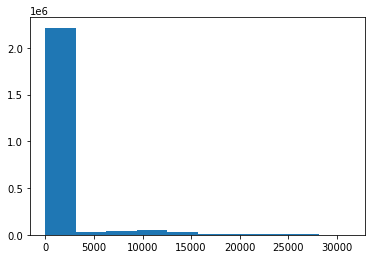

In [87]:
plt.hist(edge_distances.numpy())

(array([2.91358e+05, 1.85693e+06, 2.20559e+05, 2.40020e+04, 8.86000e+03,
        1.90000e+02, 2.09400e+03, 9.82000e+02, 3.00000e+01, 2.00000e+00]),
 array([0.09659466, 0.19802627, 0.29945788, 0.4008895 , 0.5023211 ,
        0.60375273, 0.70518434, 0.80661595, 0.90804756, 1.0094792 ,
        1.1109108 ], dtype=float32),
 <BarContainer object of 10 artists>)

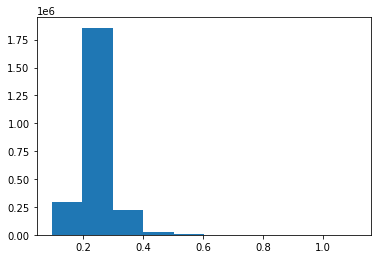

In [88]:
plt.hist(1/np.log(edge_distances.numpy()))

In [89]:
1/np.log(edge_distances.numpy()).max(), 1/np.log(edge_distances.numpy()).min()

(0.09659466088104895, 1.1109107284771018)

In [94]:
edge_distances[0:11], edge_distances[11:22]

(tensor([[   43.0353],
         [   44.5099],
         [   69.4068],
         [   70.1134],
         [   78.0212],
         [   84.8473],
         [   98.8727],
         [  102.2094],
         [  118.8012],
         [  121.6366],
         [28044.5391]]),
 tensor([[   31.8415],
         [   44.5752],
         [   47.7873],
         [   57.1006],
         [   67.6069],
         [   69.3602],
         [   69.4068],
         [   84.3566],
         [   86.2760],
         [  103.5733],
         [28094.0938]]))

In [111]:
pd.DataFrame(insar_nn_dist[:,:10]).describe()

0              1              2              3  \
count  218637.000000  218637.000000  218637.000000  218637.000000   
mean       24.378405      37.577163      48.118383      57.117312   
std        22.247588      31.544326      38.720093      44.735366   
min         2.460002       3.004994       9.144052      13.937376   
25%        15.318962      25.501325      32.825659      41.347052   
50%        20.002201      31.780754      41.808829      47.804635   
75%        29.128289      42.012897      51.460469      59.349034   
max      1155.691456    1374.746503    1387.828255    1394.632049   

                   4              5              6              7  \
count  218637.000000  218637.000000  218637.000000  218637.000000   
mean       65.295777      72.780520      79.711229      86.306187   
std        50.765935      55.771993      60.195939      65.006307   
min        20.909703      24.827208      27.513053      29.754797   
25%        45.498966      51.808888      56.525709      60.839102   
50%        55.682335      60.367626      67.032434      71.471290   
75%        68.548453      74.444821      82.646928      87.839843   
max      1412.239795    1559.607505    1603.688270    1639.518320   

                   8              9  
count  218637.000000  218637.000000  
mean       92.456584      98.473387  
std        68.410673      72.834825  
min        31.091466      37.331739  
25%        66.099884      70.132072  
50%        76.514347      82.361876  
75%        94.943792     100.043451  
max      1786.384078    1864.522646

In [109]:
pd.DataFrame(np.min(gnss_insar_dist, axis=1)).describe()

0
count  218637.000000
mean     9776.311676
std      5823.605248
min         9.687161
25%      5462.267287
50%      9446.333886
75%     12811.060053
max     31336.507605

In [10]:
with open('/cluster/scratch/mfrancesc/graph_float32.pt','wb') as f:
    pickle.dump(graph, f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('/cluster/scratch/mfrancesc/graph_float32.pt','rb') as f:
    graph = pickle.load(f)

In [3]:
graph

Data(edge_index=[2, 2405007], edge_attr=[2405007, 1], y=[218648, 1549, 1], mask=[218648, 1549], t=[1, 1549], delta_t=[218648, 1549], hop_mask=[218648, 1549], update_delta_t=[218648, 1549], num_nodes=218648)

In [4]:
def get_config(args=None):
    parser = argparse.ArgumentParser(description='Train Models')
    # If config file should be used
    parser.add_argument("--config", type=str, help="Config file to read run config from")

    # General
    parser.add_argument("--model", type=str, default="tgnn4i",
            help="Which model to use")
    
    parser.add_argument("--insar-dataset", type=str, default='data/InSAR_data/time_series_Saarland_Orbit139_update.nc',
            help="Path to insar dataset")
    parser.add_argument("--gnss-dataset", type=str, default='data/selected_stations_dates.csv',
            help="Path to gnss dataset")
    parser.add_argument("--dataset-type", type=str, default='derivative',
            help="Type of dataset to use (derivative/filtered/raw)")
    parser.add_argument("--filter_scale", type=float, default=5.,
            help="Filter scale for derivative/filtered data")
    parser.add_argument("--insar_k", type=int, default=10,
            help="Number of nearest neighbors to use for insar nodes")
    parser.add_argument("--gnss_to_insar_k", type=int, default=1,
            help="Number of nearest neighbors to use for gnss nodes")
    parser.add_argument("--insar_nn_ind_path", type=str, default='data/InSAR_data/nearest_neighbors_ind.npy',
            help="Path to insar nearest neighbor indices")
    parser.add_argument("--insar_nn_dist_path", type=str, default='data/InSAR_data/nearest_neighbors_dist.npy',
            help="Path to insar nearest neighbor distances")
    parser.add_argument("--gnss_insar_dist_path", type=str, default='data/insar_gnss_distances.npy',
            help="Path to gnss insar distances")
    parser.add_argument("--edge_weight_scaling", type=float, default=6.,
            help="Scaling of edge weights")
    parser.add_argument("--dtype", type=str, default="float32",
            help="Data type to use for torch tensors")
    
    
    
    
    parser.add_argument("--seed", type=int, default=42,
            help="Seed for random number generator")
    parser.add_argument("--optimizer", type=str, default="adam",
            help="Optimizer to use for training")
    parser.add_argument("--test", type=int, default=0,
            help="Also evaluate on test set after training is done")
    parser.add_argument("--use_features", type=int, default=1,
            help="If additional input features should be used")
    parser.add_argument("--load", type=str,
            help="Load model parameters from path")

    # Model Architecture
    parser.add_argument("--gru_layers", type=int, default=1,
            help="Layers of GRU units")
    parser.add_argument("--decay_type", type=str, default="dynamic",
            help="Parametrization of GRU decay to use (none/to_const/dynamic)")
    parser.add_argument("--periodic", type=int, default=0,
            help="If latent state dynamics should include periodic component")
    parser.add_argument("--time_input", type=int, default=1,
            help="Concatenate time (delta_t) to the input at each timestep")
    parser.add_argument("--mask_input", type=int, default=1,
            help="Concatenate the observation mask as input")
    parser.add_argument("--hidden_dim", type=int, default=32,
            help="Dimensionality of hidden state in GRU units (latent node state))")
    parser.add_argument("--n_fc", type=int, default=2,
            help="Number of fully connected layers after GRU units")
    parser.add_argument("--pred_gnn", type=int, default=1,
            help="Number of GNN-layers to use in predictive part of model")
    parser.add_argument("--gru_gnn", type=int, default=1,
            help="Number of GNN layers used for GRU-cells")
    parser.add_argument("--gnn_type", type=str, default="graphconv",
            help="Type of GNN-layers to use")
    parser.add_argument("--node_params", type=int, default=0, # I think it should be 0 if each graph has different nodes
            help="Use node-specific parameters for initial state and decay target")
    parser.add_argument("--learn_init_state", type=int, default=0, # I think it should be 0 if each graph has different nodes
            help="If the initial state of GRU-units should be learned (otherwise 0)")

    # Training
    parser.add_argument("--epochs", type=int,
            help="How many epochs to train for", default=10)
    parser.add_argument("--val_interval", type=int, default=1,
            help="Evaluate model every val_interval:th epoch")
    parser.add_argument("--patience", type=int, default=20,
            help="How many evaluations to wait for improvement in val loss")
    parser.add_argument("--lr", type=float,
            help="Learning rate", default=1e-3)
    parser.add_argument("--l2_reg", type=float,
            help="L2-regularization coefficient", default=0.)
    parser.add_argument("--state_updates", type=str, default="obs",
            help="When the node state should be updated (all/obs/hop)")
    parser.add_argument("--loss_weighting", type=str, default="const",
            help="Function to weight loss with, given as: name,param1,...,paramK")
    parser.add_argument("--max_pred", type=int, default=48,
            help="Maximum number of time indices forward to predict")

    args = parser.parse_args(args) # TODO: Changes this when to .py file without argument to read input args
    config = vars(args)

    # Read additional config from file
    if args.config:
        assert os.path.exists(args.config), "No config file: {}".format(args.config)
        with open(args.config) as json_file:
            config_from_file = json.load(json_file)

        # Make sure all options in config file also exist in argparse config.
        # Avoids choosing wrong parameters because of typos etc.
        unknown_options = set(config_from_file.keys()).difference(set(config.keys()))
        unknown_error = "\n".join(["Unknown option in config file: {}".format(opt)
            for opt in unknown_options])
        assert (not unknown_options), unknown_error

        config.update(config_from_file)

    # Some asserts
    assert config["model"] in MODELS, f"Unknown model: {config['model']}"
    assert config["optimizer"] in constants.OPTIMIZERS, (
            f"Unknown optimizer: {config['optimizer']}")

    assert config["gnn_type"] in constants.GNN_LAYERS, (
            f"Unknown gnn_type: {config['gnn_type']}")
    assert (not bool(config["periodic"])) or (config["hidden_dim"] % 2 == 0), (
            "hidden_dim must be even when using periodic latent dynamics")
    
    if config["dtype"] == "float16":
        config["dtype"] = torch.float16
    elif config["dtype"] == "float32":
        config["dtype"] = torch.float32
    else:
        raise ValueError(f"Unknown dtype: {config['dtype']}")

    return config

In [5]:
MODELS = {
    "grud_joint": GRUModel, # Ignore graph structure, evolve single joint latent state
    "grud_node": GRUNodeModel, # Treat each node independently, independent latent state
    "tgnn4i": GRUGraphModel, # Utilizes graph structure
    "transformer_node": TransformerForecaster,
    "transformer_joint": TransformerJointForecaster,
}

config=get_config('')
if torch.cuda.is_available():
    device = torch.device("cuda")

    # For reproducability on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")

In [6]:
graph

Data(edge_index=[2, 2405007], edge_attr=[2405007, 1], y=[218648, 1549, 1], mask=[218648, 1549], t=[1, 1549], delta_t=[218648, 1549], hop_mask=[218648, 1549], update_delta_t=[218648, 1549], num_nodes=218648)

In [19]:
train = torch.load("data/InSAR_data/train_ind.pt")

In [20]:
batch_size = 16
neighbor_loader = ptg.loader.NeighborLoader(graph,
                                            num_neighbors=[11],
                                            input_nodes=train,
                                            batch_size=batch_size,
                                            disjoint=True,
                                            pin_memory=True)

In [22]:
train.shape

torch.Size([153045])

In [21]:
len(neighbor_loader)

9566

In [7]:
input_nodes = torch.BoolTensor(graph.num_nodes)
n_insar = 218637
input_nodes[:n_insar] = True
input_nodes[n_insar:] = False

In [8]:
batch_size = 16
neighbor_loader = ptg.loader.NeighborLoader(graph,
                                            num_neighbors=[11],
                                            input_nodes=input_nodes,
                                            batch_size=batch_size,
                                            disjoint=True,
                                            pin_memory=True)

In [9]:
len(neighbor_loader)

13665

In [10]:
config["num_nodes"] = 12
config["time_steps"] = 1549
config["device"] = device
config["y_dim"] = 1
'''
config["has_features"] = hasattr(batch, "features") and\
    bool(config["use_features"]) # TODO: not done yet
if config["has_features"]:
    config["feature_dim"] = batch.features.shape[-1]
else:
'''
config["has_features"] = False
config["feature_dim"] = 0

config["param_dim"] = 1 #  to simplify we just predict the mean
loss_weight_func = parse_loss_weight(config["loss_weighting"])

In [11]:
batch = next(iter(neighbor_loader))
batch = batch.to(config["device"]) # Move all graphs to GPU

In [12]:
batch

Data(edge_index=[2, 176], edge_attr=[176, 1], y=[192, 1549, 1], mask=[192, 1549], t=[1, 1549], delta_t=[192, 1549], hop_mask=[192, 1549], update_delta_t=[192, 1549], num_nodes=192, n_id=[192], e_id=[176], batch=[192], num_sampled_nodes=[2], num_sampled_edges=[1], input_id=[16], batch_size=16)

In [13]:
batch.input_id

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')

In [14]:
batch.edge_index

tensor([[ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
          30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
          44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
          58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
          72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
          86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
         100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
         114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
         128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
         142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
         170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
         184, 185, 186, 187, 188, 189, 190, 191],
  

In [15]:
batch.t = batch.t.repeat(batch_size,1)

In [16]:
batch.num_graphs = batch_size

In [17]:
model = MODELS[config["model"]](config)
model.to(device)

GRUGraphModel(
  (gru_cells): ModuleList(
    (0): GRUGraphCell(
      (input_gnn): Sequential(
        (0) - GraphConv(3, 224): x, edge_index, edge_weight -> x
      )
      (state_gnn): Sequential(
        (0) - GraphConv(32, 224): x, edge_index, edge_weight -> x
      )
    )
  )
  (post_gru_layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (pred_gnn_model): Sequential(
    (0) - GraphConv(33, 32): x, edge_index, edge_weight -> x
  )
)

In [18]:
full_pred_params, pred_delta_times = model.forward(
                batch) # (N_T, B*N, max_pred, d_y, d_param) and (N_T, B, max_pred)
print("Full pred params: ", full_pred_params.shape)
print("Pred delta times: ", pred_delta_times.shape)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.75 GiB total capacity; 9.44 GiB already allocated; 11.62 MiB free; 9.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF